In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/My\ Drive/

/content/gdrive/My Drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# **1. Data Pre-Processing**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
import pickle


In [ ]:
# Load training data 
endpoint_data =  pd.read_csv("hecktor2021_patient_endpoint_training.csv")
endpoint_data = endpoint_data.drop(labels=206, axis=0) # missing ct image
print(endpoint_data)

    PatientID  Progression  Progression free survival
0     CHGJ007            1                        310
1     CHGJ008            0                       2037
2     CHGJ010            0                       1917
3     CHGJ013            0                       1377
4     CHGJ015            0                       1072
..        ...          ...                        ...
219   CHUP019            1                        161
220   CHUP020            1                        394
221   CHUP021            0                        874
222   CHUP022            0                       2401
223   CHUP023            1                        402

[223 rows x 3 columns]


In [ ]:
# Read the clinical dataset 
info_data = pd.read_csv("hecktor2021_patient_info_training.csv")
clinical = info_data.sort_values(by = 'PatientID')
clinical = clinical.drop(labels=206, axis=0)  
clinical=clinical.drop(columns=['Estimated weight (kg) for SUV','CenterID'])
clinical = clinical.rename({'T-stage': 'Tstage', 'N-stage': 'Nstage', 'M-stage': 'Mstage', 'TNM group':'TNMgroup'}, axis='columns')

# Reset the index in ascending order
clinical = clinical.reset_index(drop=True)
clinical.to_csv('/content/gdrive/My Drive/clinical.csv')
print (clinical)

    PatientID  Gender (1=M,0=F)  ...  HPV status (0=-, 1=+)  Chemotherapy
0     CHGJ007                 1  ...                    1.0             1
1     CHGJ008                 1  ...                    NaN             1
2     CHGJ010                 0  ...                    0.0             1
3     CHGJ013                 0  ...                    1.0             1
4     CHGJ015                 0  ...                    NaN             1
..        ...               ...  ...                    ...           ...
218   CHUS096                 1  ...                    1.0             0
219   CHUS097                 1  ...                    1.0             1
220   CHUS098                 1  ...                    1.0             1
221   CHUS100                 1  ...                    1.0             1
222   CHUS101                 1  ...                    0.0             1

[223 rows x 13 columns]


In [ ]:
# Read the clinical test dataset 
test_data = pd.read_csv("hecktor2021_patient_info_testing.csv")
test = test_data.sort_values(by = 'PatientID_hecktor')
test = test.drop(columns=['Estimated weight (kg) for SUV','CenterID'])
test = test.rename({'T-stage': 'Tstage', 'N-stage': 'Nstage', 'M-stage': 'Mstage', 'TNM group':'TNMgroup'}, axis='columns')

# Reset the index in ascending order
test = test.reset_index(drop=True)
test.to_csv('/content/gdrive/My Drive/test.csv')
print (test)

    PatientID_hecktor  Gender (1=M,0=F)  ...  HPV status (0=-, 1=+)  Chemotherapy
0             CHUP025                 1  ...                    0.0             1
1             CHUP026                 1  ...                    0.0             1
2             CHUP027                 1  ...                    0.0             1
3             CHUP028                 1  ...                    NaN             1
4             CHUP029                 0  ...                    0.0             1
..                ...               ...  ...                    ...           ...
96            CHUV049                 1  ...                    NaN             1
97            CHUV050                 0  ...                    NaN             1
98            CHUV051                 1  ...                    NaN             1
99            CHUV052                 0  ...                    NaN             1
100           CHUV053                 1  ...                    NaN             1

[101 rows x 13 

In [ ]:
test['PatientID'] = test['PatientID_hecktor'] #rename column for correspondence

In [ ]:
test = test.drop(columns=['Performance status_2.0'])

Create dummy variables for the categorical data


In [ ]:

clinical['Tstage']=clinical.Tstage.apply(lambda x: 0 if x=='T1' 
                                                      else 1 if x=='T2' 
                                                      else 2 if x=='T3' 
                                                      else 3)

clinical['Nstage']=clinical.Nstage.apply(lambda x: 0 if x == 'N0' 
                                                      else 1 if x=='N1' 
                                                      else 2 if x in('N2', 'N2a','N2b','N2c') 
                                                      else 3)

clinical['Mstage']=clinical.Nstage.apply(lambda x: 0 if x == 'M0' 
                                                      else 1)
clinical['TNMgroup']=clinical.TNMgroup.apply(lambda x: 0 if x == 'I' 
                                                      else 1 if x=='II' 
                                                      else 2 if x=='III' 
                                                      else 3) 

categories = ['Tstage','Nstage','Mstage','TNMgroup','Tobacco','Alcohol','Gender (1=M,0=F)','Performance status','TNM edition','HPV status (0=-, 1=+)']
clinical = pd.get_dummies(clinical, columns=categories, drop_first=True)


Repeat process for test set

In [ ]:

test['Tstage']=test.Tstage.apply(lambda x: 0 if x=='T1' 
                                                      else 1 if x=='T2' 
                                                      else 2 if x=='T3' 
                                                      else 3)

test['Nstage']=test.Nstage.apply(lambda x: 0 if x == 'N0' 
                                                      else 1 if x=='N1' 
                                                      else 2 if x in('N2', 'N2a','N2b','N2c') 
                                                      else 3)

test['Mstage']=test.Nstage.apply(lambda x: 0 if x == 'M0' 
                                                      else 1)
test['TNMgroup']=test.TNMgroup.apply(lambda x: 0 if x == 'I' 
                                                      else 1 if x=='II' 
                                                      else 2 if x=='III' 
                                                      else 3) 

categories = ['Tstage','Nstage','Mstage','TNMgroup','Tobacco','Alcohol','Gender (1=M,0=F)','Performance status','TNM edition','HPV status (0=-, 1=+)']
test = pd.get_dummies(test, columns=categories, drop_first=True)

Read extracted pet features

In [ ]:

def extract_pet_features(path_pet_features):
    pet_features = pd.read_csv(path_pet_features)
    # Sort the rows of dataframe by 'Name' column
    pet_features = pet_features.sort_values(by = 'patients_id')
    # Reset the index in ascending order
    pet_features = pet_features.reset_index(drop=True)
    return pet_features

pet_features = extract_pet_features("extracted_features_pet.csv")
pet_features_test = extract_pet_features("extracted_features_pet_test.csv")

    patients_id  ... original_ngtdm_Strength
0       CHGJ007  ...                     1.0
1       CHGJ008  ...                     0.0
2       CHGJ010  ...                     0.0
3       CHGJ013  ...                     0.0
4       CHGJ015  ...                     0.0
..          ...  ...                     ...
218     CHUS096  ...                     0.0
219     CHUS097  ...                     0.0
220     CHUS098  ...                     0.0
221     CHUS100  ...                     0.0
222     CHUS101  ...                     0.0

[223 rows x 130 columns]


Read extracted ct features

In [ ]:

def extract_ct_features(path_ct_features):
    ct_features = pd.read_csv(path_ct_features)
    # Sort the rows of dataframe by 'Name' column
    ct_features = ct_features.sort_values(by = 'patients_id')
    # Reset the index in ascending order
    ct_features = ct_features.reset_index(drop=True)
    return ct_features

ct_features = extract_pet_features("extracted_features_ct.csv")
test_ct_features = extract_pet_features("extracted_features_ct_test.csv")
print (ct_features)

    patients_id  ... original_ngtdm_Strength
0       CHGJ007  ...                     1.0
1       CHGJ008  ...                     0.0
2       CHGJ010  ...                     0.0
3       CHGJ013  ...                     0.0
4       CHGJ015  ...                     0.0
..          ...  ...                     ...
218     CHUS096  ...                     0.0
219     CHUS097  ...                     0.0
220     CHUS098  ...                     0.0
221     CHUS100  ...                     0.0
222     CHUS101  ...                     0.0

[223 rows x 130 columns]


Read extracted deep features

In [ ]:

def extract_deep_features(path_deep_features):
    deep_features = pd.read_csv(path_deep_features)
    deep_features = deep_features.rename(columns={'Unnamed: 0': 'PatientID'})
    # Sort the rows of dataframe by 'Name' column
    deep_features = deep_features.sort_values(by = 'PatientID')
    # Reset the index in ascending order
    deep_features = deep_features.reset_index(drop=True)
    return deep_features

deep_features = extract_deep_features("features_unet.csv")
test_deep_features = extract_deep_features("features_unet_test.csv")


In [ ]:
print(test_deep_features)

    PatientID          0          1  ...        141        142        143
0     CHUP040   1.561144   2.663644  ...  10.427158   5.928310  -0.931872
1     CHUP060   3.707203   6.315398  ...  14.774714  15.243038  10.462632
2     CHUV025   0.246460   1.112381  ...  12.781462   6.786904  -0.822516
3     CHUP034   6.571823   9.034449  ...  20.070354  21.655520  15.204715
4     CHUP054  -0.531894  -0.320032  ...  36.351437  22.548420   4.281902
..        ...        ...        ...  ...        ...        ...        ...
96    CHUP061  23.884945  32.692055  ...   9.529576   5.397012  -1.686181
97    CHUV010   1.771936   2.714971  ...  40.131660  22.852820   4.033140
98    CHUP055   0.946515   1.620571  ...  25.121386  26.151447  20.205112
99    CHUP049  13.689615  18.164381  ...  28.405163  17.439287   2.066371
100   CHUV006   3.084119   4.423283  ...  26.422005  16.003588   1.538562

[101 rows x 145 columns]


# Multiple imputation for missing values (clinical data)

In [ ]:
#Select numerical columns 
numeric_cols = clinical.drop(columns=['PatientID']).select_dtypes(exclude='number')
clinical.drop(numeric_cols, axis=1, inplace=True)
numeric_cols = test.drop(columns=['PatientID']).select_dtypes(exclude='number')
test.drop(numeric_cols, axis=1, inplace=True)

In [ ]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman',random_state=0)

clinical_imputed=imp.fit_transform(clinical.drop(columns=['PatientID']))
clinical_imputed = pd.DataFrame(clinical_imputed, columns = test.drop(columns=['PatientID']).columns)
test_imputed=imp.fit_transform(test.drop(columns=['PatientID']))
test_imputed = pd.DataFrame(test_imputed, columns = test.drop(columns=['PatientID']).columns)


[IterativeImputer] Completing matrix with shape (101, 17)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.02
[IterativeImputer] Change: 0.0, scaled tolerance: 0.084 
[IterativeImputer] Early stopping criterion reached.


# Data Merging and Train-Test Split



In [ ]:
# Several models were tested with a combination of clinical, ct, pet and deep features. 
# Best results obtained with a mixture of clinical, ct and deep features.

data = pd.concat([clinical_imputed, ct_features], axis=1, join='inner',ignore_index=False, sort=False)
data = pd.concat([data, ct_features], axis=1, join='inner',ignore_index=False, sort=False)

data_test = pd.concat([test_imputed, deep_features],axis=1,join='inner',ignore_index=False, sort=False)
data_test = pd.concat([data_test, test_ct_features],axis=1,join='inner',ignore_index=False, sort=False)


In [ ]:
# Separate into training and test set for model training 
X_train, X_val, y_train, y_val = train_test_split(data,
    endpoint_data['Progression free survival'],
    test_size=0.3,
    random_state=0) 
X_train.shape, X_test.shape

((156, 274), (67, 274))

# Features Selection using Lasso

In [ ]:
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [ ]:
# Lasso regression with 5-fold cross-validation 
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

In [ ]:

search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [ ]:
search.fit(X_train.drop(columns=['PatientID']),y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV] model__alpha=0.1 ................................................
[CV] ............. model__alpha=0.1, score=-2156395.654, total=   0.1s
[CV] model__alpha=0.1 ................................................
[CV] ............. model__alpha=0.1, score=-2082862.270, total=   0.1s
[CV] model__alpha=0.1 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201042.2283021267, tolerance: 4371.369048387098
  positive)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226098.1583161126, tolerance: 4494.4464272
  positive)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186306.61835188628, tolerance: 4545.20

[CV] ............. model__alpha=0.1, score=-1864616.813, total=   0.1s
[CV] model__alpha=0.1 ................................................
[CV] ............. model__alpha=0.1, score=-2313447.520, total=   0.1s
[CV] model__alpha=0.1 ................................................
[CV] ............. model__alpha=0.1, score=-1086335.249, total=   0.1s
[CV] model__alpha=0.2 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260917.27798686028, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299521.42307358637, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303629.0674963844, tolerance: 4545.2030112
  positive)


[CV] ............. model__alpha=0.2, score=-1911140.795, total=   0.1s
[CV] model__alpha=0.2 ................................................
[CV] ............. model__alpha=0.2, score=-1999924.606, total=   0.1s
[CV] model__alpha=0.2 ................................................
[CV] ............. model__alpha=0.2, score=-2090053.844, total=   0.1s
[CV] model__alpha=0.2 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357524.27323701326, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 286194.4824812032, tolerance: 4269.2907392
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263020.02520375734, tolerance: 4371.369048387098
  positive)


[CV] ............. model__alpha=0.2, score=-2252088.935, total=   0.1s
[CV] model__alpha=0.2 ................................................
[CV] ............. model__alpha=0.2, score=-1033028.818, total=   0.1s
[CV] model__alpha=0.30000000000000004 ................................
[CV]  model__alpha=0.30000000000000004, score=-1648076.775, total=   0.1s
[CV] model__alpha=0.30000000000000004 ................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366551.1796285652, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311750.2904430999, tolerance: 4545.2030112
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302538.57380262966, tolerance: 4930.625720000001
  positive)


[CV]  model__alpha=0.30000000000000004, score=-1887402.650, total=   0.1s
[CV] model__alpha=0.30000000000000004 ................................
[CV]  model__alpha=0.30000000000000004, score=-2196746.241, total=   0.1s
[CV] model__alpha=0.30000000000000004 ................................
[CV]  model__alpha=0.30000000000000004, score=-2193159.401, total=   0.1s
[CV] model__alpha=0.30000000000000004 ................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 383871.33509416314, tolerance: 4269.2907392
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196827.84974216914, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368295.41722774616, tolerance: 4494.4464272
  positive)


[CV]  model__alpha=0.30000000000000004, score=-1019066.326, total=   0.1s
[CV] model__alpha=0.4 ................................................
[CV] ............. model__alpha=0.4, score=-1551867.439, total=   0.1s
[CV] model__alpha=0.4 ................................................
[CV] ............. model__alpha=0.4, score=-1800458.036, total=   0.1s
[CV] model__alpha=0.4 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 268590.1386394501, tolerance: 4545.2030112
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 416421.1731450056, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 395632.46908487886, tolerance: 4269.2907392
  positive)


[CV] ............. model__alpha=0.4, score=-2236126.210, total=   0.1s
[CV] model__alpha=0.4 ................................................
[CV] ............. model__alpha=0.4, score=-2071473.051, total=   0.1s
[CV] model__alpha=0.4 ................................................
[CV] .............. model__alpha=0.4, score=-978423.104, total=   0.1s
[CV] model__alpha=0.5 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267456.87399684824, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 535479.5592029078, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 306975.1612265267, tolerance: 4545.2030112
  positive)


[CV] ............. model__alpha=0.5, score=-1532323.603, total=   0.1s
[CV] model__alpha=0.5 ................................................
[CV] ............. model__alpha=0.5, score=-1737728.666, total=   0.1s
[CV] model__alpha=0.5 ................................................
[CV] ............. model__alpha=0.5, score=-2185563.040, total=   0.1s
[CV] model__alpha=0.5 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 582465.9480327044, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 330265.8066317923, tolerance: 4269.2907392
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 310507.9285904238, tolerance: 4371.369048387098
  positive)


[CV] ............. model__alpha=0.5, score=-1972532.713, total=   0.1s
[CV] model__alpha=0.5 ................................................
[CV] .............. model__alpha=0.5, score=-944281.429, total=   0.1s
[CV] model__alpha=0.6 ................................................
[CV] ............. model__alpha=0.6, score=-1441678.618, total=   0.1s
[CV] model__alpha=0.6 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 668728.7617542257, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323831.06734942994, tolerance: 4545.2030112
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 519155.37144869403, tolerance: 4930.625720000001
  positive)


[CV] ............. model__alpha=0.6, score=-1673903.147, total=   0.1s
[CV] model__alpha=0.6 ................................................
[CV] ............. model__alpha=0.6, score=-2122847.292, total=   0.1s
[CV] model__alpha=0.6 ................................................
[CV] ............. model__alpha=0.6, score=-1843053.723, total=   0.1s
[CV] model__alpha=0.6 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278403.8874638146, tolerance: 4269.2907392
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 294203.52253975795, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 615001.6786087767, tolerance: 4494.4464272
  positive)


[CV] .............. model__alpha=0.6, score=-948968.772, total=   0.1s
[CV] model__alpha=0.7000000000000001 .................................
[CV]  model__alpha=0.7000000000000001, score=-1351030.138, total=   0.1s
[CV] model__alpha=0.7000000000000001 .................................
[CV]  model__alpha=0.7000000000000001, score=-1648925.863, total=   0.1s
[CV] model__alpha=0.7000000000000001 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275254.1695169954, tolerance: 4545.2030112
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333395.2076474763, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178773.34817370458, tolerance: 4269.2907392
  positive)


[CV]  model__alpha=0.7000000000000001, score=-2054675.173, total=   0.1s
[CV] model__alpha=0.7000000000000001 .................................
[CV]  model__alpha=0.7000000000000001, score=-1725209.524, total=   0.1s
[CV] model__alpha=0.7000000000000001 .................................
[CV]  model__alpha=0.7000000000000001, score=-943566.106, total=   0.1s
[CV] model__alpha=0.8 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196177.7730167855, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 591911.3584137438, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241955.3970766241, tolerance: 4545.2030112
  positive)


[CV] ............. model__alpha=0.8, score=-1262858.098, total=   0.1s
[CV] model__alpha=0.8 ................................................
[CV] ............. model__alpha=0.8, score=-1652710.210, total=   0.1s
[CV] model__alpha=0.8 ................................................
[CV] ............. model__alpha=0.8, score=-1970604.655, total=   0.1s
[CV] model__alpha=0.8 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 470758.4233836379, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167200.84729428403, tolerance: 4269.2907392
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182023.3181027989, tolerance: 4371.369048387098
  positive)


[CV] ............. model__alpha=0.8, score=-1647663.777, total=   0.1s
[CV] model__alpha=0.8 ................................................
[CV] .............. model__alpha=0.8, score=-947283.376, total=   0.1s
[CV] model__alpha=0.9 ................................................
[CV] ............. model__alpha=0.9, score=-1174680.520, total=   0.1s
[CV] model__alpha=0.9 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 654078.7306808069, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 207531.93906937033, tolerance: 4545.2030112
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546544.1306186855, tolerance: 4930.625720000001
  positive)


[CV] ............. model__alpha=0.9, score=-1679153.177, total=   0.1s
[CV] model__alpha=0.9 ................................................
[CV] ............. model__alpha=0.9, score=-1874604.304, total=   0.1s
[CV] model__alpha=0.9 ................................................
[CV] ............. model__alpha=0.9, score=-1581471.164, total=   0.1s
[CV] model__alpha=0.9 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156876.83638037485, tolerance: 4269.2907392
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180748.3678482289, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 274614.6821022853, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 232178.19645289378, t

[CV] .............. model__alpha=0.9, score=-954653.340, total=   0.1s
[CV] model__alpha=1.0 ................................................
[CV] ............. model__alpha=1.0, score=-1104068.055, total=   0.1s
[CV] model__alpha=1.0 ................................................
[CV] ............. model__alpha=1.0, score=-1712765.962, total=   0.1s
[CV] model__alpha=1.0 ................................................
[CV] ............. model__alpha=1.0, score=-1782657.765, total=   0.1s
[CV] model__alpha=1.0 ................................................
[CV] ............. model__alpha=1.0, score=-1511815.455, total=   0.1s
[CV] model__alpha=1.0 ................................................
[CV] .............. model__alpha=1.0, score=-974655.189, total=   0.1s
[CV] model__alpha=1.1 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 616348.4733829282, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105368.55218593823, tolerance: 4269.2907392
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226445.1710465037, tolerance: 4371.369048387098
  positive)


[CV] ............. model__alpha=1.1, score=-1050084.663, total=   0.1s
[CV] model__alpha=1.1 ................................................
[CV] ............. model__alpha=1.1, score=-1747447.490, total=   0.1s
[CV] model__alpha=1.1 ................................................
[CV] ............. model__alpha=1.1, score=-1694544.206, total=   0.1s
[CV] model__alpha=1.1 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 242726.3388896149, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229868.40320479497, tolerance: 4545.2030112
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 622369.32657653, tolerance: 4930.625720000001
  positive)


[CV] ............. model__alpha=1.1, score=-1470095.467, total=   0.1s
[CV] model__alpha=1.1 ................................................
[CV] .............. model__alpha=1.1, score=-984893.538, total=   0.1s
[CV] model__alpha=1.2000000000000002 .................................
[CV]  model__alpha=1.2000000000000002, score=-1019749.328, total=   0.1s
[CV] model__alpha=1.2000000000000002 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90859.73361631215, tolerance: 4269.2907392
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133435.21168538858, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220568.62696801685, tolerance: 4494.4464272
  positive)


[CV]  model__alpha=1.2000000000000002, score=-1757559.358, total=   0.1s
[CV] model__alpha=1.2000000000000002 .................................
[CV]  model__alpha=1.2000000000000002, score=-1627032.094, total=   0.1s
[CV] model__alpha=1.2000000000000002 .................................
[CV]  model__alpha=1.2000000000000002, score=-1424899.713, total=   0.1s
[CV] model__alpha=1.2000000000000002 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198177.23904479074, tolerance: 4545.2030112
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 611543.2537915421, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84008.6606461429, tolerance: 4269.2907392
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102043.73772264807, to

[CV]  model__alpha=1.2000000000000002, score=-992399.195, total=   0.1s
[CV] model__alpha=1.3000000000000003 .................................
[CV]  model__alpha=1.3000000000000003, score=-996613.236, total=   0.1s
[CV] model__alpha=1.3000000000000003 .................................
[CV]  model__alpha=1.3000000000000003, score=-1754199.097, total=   0.1s
[CV] model__alpha=1.3000000000000003 .................................
[CV]  model__alpha=1.3000000000000003, score=-1595696.245, total=   0.1s
[CV] model__alpha=1.3000000000000003 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175884.69146656664, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144015.01217363472, tolerance: 4545.2030112
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 584901.9553536575, tolerance: 4930.625720000001
  positive)


[CV]  model__alpha=1.3000000000000003, score=-1377185.580, total=   0.1s
[CV] model__alpha=1.3000000000000003 .................................
[CV]  model__alpha=1.3000000000000003, score=-1005091.371, total=   0.1s
[CV] model__alpha=1.4000000000000001 .................................
[CV]  model__alpha=1.4000000000000001, score=-976070.240, total=   0.1s
[CV] model__alpha=1.4000000000000001 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76666.65135571081, tolerance: 4269.2907392
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98107.7099647324, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137529.07735410938, tolerance: 4494.4464272
  positive)


[CV]  model__alpha=1.4000000000000001, score=-1735407.846, total=   0.1s
[CV] model__alpha=1.4000000000000001 .................................
[CV]  model__alpha=1.4000000000000001, score=-1564177.422, total=   0.1s
[CV] model__alpha=1.4000000000000001 .................................
[CV]  model__alpha=1.4000000000000001, score=-1334855.985, total=   0.1s
[CV] model__alpha=1.4000000000000001 .................................
[CV]  model__alpha=1.4000000000000001, score=-1005044.436, total=   0.1s
[CV] model__alpha=1.5000000000000002 .................................

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139471.6042656526, tolerance: 4545.2030112
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 575030.6050039921, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84533.66374175856, tolerance: 4269.2907392
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77218.90229638969, tol


[CV]  model__alpha=1.5000000000000002, score=-961940.373, total=   0.1s
[CV] model__alpha=1.5000000000000002 .................................
[CV]  model__alpha=1.5000000000000002, score=-1710478.922, total=   0.1s
[CV] model__alpha=1.5000000000000002 .................................
[CV]  model__alpha=1.5000000000000002, score=-1517355.596, total=   0.1s
[CV] model__alpha=1.5000000000000002 .................................

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122722.3065123572, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95032.34692543698, tolerance: 4545.2030112
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 513352.3948870925, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47902.368504586164, to


[CV]  model__alpha=1.5000000000000002, score=-1295114.629, total=   0.1s
[CV] model__alpha=1.5000000000000002 .................................
[CV]  model__alpha=1.5000000000000002, score=-995266.878, total=   0.1s
[CV] model__alpha=1.6 ................................................
[CV] .............. model__alpha=1.6, score=-941690.543, total=   0.1s
[CV] model__alpha=1.6 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80418.91276068008, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118383.85682382039, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94631.16483609541, tolerance: 4545.2030112
  positive)


[CV] ............. model__alpha=1.6, score=-1678900.785, total=   0.1s
[CV] model__alpha=1.6 ................................................
[CV] ............. model__alpha=1.6, score=-1472719.173, total=   0.1s
[CV] model__alpha=1.6 ................................................
[CV] ............. model__alpha=1.6, score=-1248357.543, total=   0.1s
[CV] model__alpha=1.6 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358793.21805138374, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55850.09555229684, tolerance: 4269.2907392
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83648.4168152716, tolerance: 4371.369048387098
  positive)


[CV] .............. model__alpha=1.6, score=-987476.438, total=   0.1s
[CV] model__alpha=1.7000000000000002 .................................
[CV]  model__alpha=1.7000000000000002, score=-1076925.217, total=   0.1s
[CV] model__alpha=1.7000000000000002 .................................
[CV]  model__alpha=1.7000000000000002, score=-1650574.018, total=   0.1s
[CV] model__alpha=1.7000000000000002 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96267.90341368597, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82039.29183077766, tolerance: 4545.2030112
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249802.84927176242, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56628.05317861773, to

[CV]  model__alpha=1.7000000000000002, score=-1429271.464, total=   0.1s
[CV] model__alpha=1.7000000000000002 .................................
[CV]  model__alpha=1.7000000000000002, score=-1211279.733, total=   0.1s
[CV] model__alpha=1.7000000000000002 .................................
[CV]  model__alpha=1.7000000000000002, score=-980801.541, total=   0.1s
[CV] model__alpha=1.8000000000000003 .................................
[CV]  model__alpha=1.8000000000000003, score=-1325131.592, total=   0.1s
[CV] model__alpha=1.8000000000000003 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57285.707520481665, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102706.27986403368, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77852.20070231217, tolerance: 4545.2030112
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213022.566254294, to

[CV]  model__alpha=1.8000000000000003, score=-1622104.636, total=   0.1s
[CV] model__alpha=1.8000000000000003 .................................
[CV]  model__alpha=1.8000000000000003, score=-1390079.785, total=   0.1s
[CV] model__alpha=1.8000000000000003 .................................
[CV]  model__alpha=1.8000000000000003, score=-1183728.497, total=   0.1s
[CV] model__alpha=1.8000000000000003 .................................
[CV]  model__alpha=1.8000000000000003, score=-975831.266, total=   0.1s
[CV] model__alpha=1.9000000000000001 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54673.62232789351, tolerance: 4269.2907392
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37613.96367826406, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106134.11661584768, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79520.40881998953, to

[CV]  model__alpha=1.9000000000000001, score=-1546452.448, total=   0.1s
[CV] model__alpha=1.9000000000000001 .................................
[CV]  model__alpha=1.9000000000000001, score=-1597292.368, total=   0.1s
[CV] model__alpha=1.9000000000000001 .................................
[CV]  model__alpha=1.9000000000000001, score=-1357644.430, total=   0.1s
[CV] model__alpha=1.9000000000000001 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215256.5683894693, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53066.27171197068, tolerance: 4269.2907392
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27727.04501916375, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103660.9417999386

[CV]  model__alpha=1.9000000000000001, score=-1169926.150, total=   0.1s
[CV] model__alpha=1.9000000000000001 .................................
[CV]  model__alpha=1.9000000000000001, score=-965873.971, total=   0.1s
[CV] model__alpha=2.0 ................................................
[CV] ............. model__alpha=2.0, score=-1704635.876, total=   0.1s
[CV] model__alpha=2.0 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75545.87515511364, tolerance: 4545.2030112
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194796.63259338727, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48920.43118846929, tolerance: 4269.2907392
  positive)


[CV] ............. model__alpha=2.0, score=-1570095.744, total=   0.1s
[CV] model__alpha=2.0 ................................................
[CV] ............. model__alpha=2.0, score=-1328513.746, total=   0.1s
[CV] model__alpha=2.0 ................................................
[CV] ............. model__alpha=2.0, score=-1154502.612, total=   0.1s
[CV] model__alpha=2.0 ................................................
[CV] .............. model__alpha=2.0, score=-952770.170, total=   0.1s
[CV] model__alpha=2.1 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21947.07486257376, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111107.89342655754, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83237.3024841426, tolerance: 4545.2030112
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159706.21771234693, to

[CV] ............. model__alpha=2.1, score=-1894727.684, total=   0.1s
[CV] model__alpha=2.1 ................................................
[CV] ............. model__alpha=2.1, score=-1540088.464, total=   0.1s
[CV] model__alpha=2.1 ................................................
[CV] ............. model__alpha=2.1, score=-1300216.540, total=   0.1s
[CV] model__alpha=2.1 ................................................
[CV] ............. model__alpha=2.1, score=-1128826.607, total=   0.1s
[CV] model__alpha=2.1 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36626.93560081208, tolerance: 4269.2907392
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17739.975969154388, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109227.66598487552, tolerance: 4494.4464272
  positive)


[CV] .............. model__alpha=2.1, score=-946335.267, total=   0.1s
[CV] model__alpha=2.2 ................................................
[CV] ............. model__alpha=2.2, score=-2135590.088, total=   0.1s
[CV] model__alpha=2.2 ................................................
[CV] ............. model__alpha=2.2, score=-1505828.531, total=   0.1s
[CV] model__alpha=2.2 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84987.28228648333, tolerance: 4545.2030112
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137780.54366340302, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26199.117889273446, tolerance: 4269.2907392
  positive)


[CV] ............. model__alpha=2.2, score=-1271902.640, total=   0.1s
[CV] model__alpha=2.2 ................................................
[CV] ............. model__alpha=2.2, score=-1102113.029, total=   0.1s
[CV] model__alpha=2.2 ................................................
[CV] .............. model__alpha=2.2, score=-942335.602, total=   0.1s
[CV] model__alpha=2.3000000000000003 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12830.244126089849, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99989.12915789429, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89327.41214035312, tolerance: 4545.2030112
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109284.997428298, tol

[CV]  model__alpha=2.3000000000000003, score=-2406355.521, total=   0.1s
[CV] model__alpha=2.3000000000000003 .................................
[CV]  model__alpha=2.3000000000000003, score=-1464902.758, total=   0.1s
[CV] model__alpha=2.3000000000000003 .................................
[CV]  model__alpha=2.3000000000000003, score=-1241739.750, total=   0.1s
[CV] model__alpha=2.3000000000000003 .................................
[CV]  model__alpha=2.3000000000000003, score=-1079659.428, total=   0.1s
[CV] model__alpha=2.3000000000000003 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14845.5375979878, tolerance: 4269.2907392
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13470.252440999728, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101089.10403702362, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100923.53927286528, t

[CV]  model__alpha=2.3000000000000003, score=-941330.799, total=   0.1s
[CV] model__alpha=2.4000000000000004 .................................
[CV]  model__alpha=2.4000000000000004, score=-3091018.179, total=   0.1s
[CV] model__alpha=2.4000000000000004 .................................
[CV]  model__alpha=2.4000000000000004, score=-1425917.238, total=   0.1s
[CV] model__alpha=2.4000000000000004 .................................
[CV]  model__alpha=2.4000000000000004, score=-1211849.379, total=   0.1s
[CV] model__alpha=2.4000000000000004 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81365.65736196283, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7149.545037634205, tolerance: 4269.2907392
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16804.996300997213, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109547.920068436

[CV]  model__alpha=2.4000000000000004, score=-1068791.914, total=   0.1s
[CV] model__alpha=2.4000000000000004 .................................
[CV]  model__alpha=2.4000000000000004, score=-937144.066, total=   0.1s
[CV] model__alpha=2.5000000000000004 .................................
[CV]  model__alpha=2.5000000000000004, score=-4142714.352, total=   0.1s
[CV] model__alpha=2.5000000000000004 .................................
[CV]  model__alpha=2.5000000000000004, score=-1387907.056, total=   0.1s
[CV] model__alpha=2.5000000000000004 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20262.053847324103, tolerance: 4545.2030112
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70370.03003157303, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5561.347387214191, tolerance: 4269.2907392
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17143.572497297544, t

[CV]  model__alpha=2.5000000000000004, score=-1190882.230, total=   0.1s
[CV] model__alpha=2.5000000000000004 .................................
[CV]  model__alpha=2.5000000000000004, score=-1060526.151, total=   0.1s
[CV] model__alpha=2.5000000000000004 .................................
[CV]  model__alpha=2.5000000000000004, score=-928007.063, total=   0.1s
[CV] model__alpha=2.6 ................................................
[CV] ............. model__alpha=2.6, score=-5032953.788, total=   0.1s
[CV] model__alpha=2.6 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123502.90487557836, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8674.561126993038, tolerance: 4545.2030112
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52847.78045572247, tolerance: 4930.625720000001
  positive)


[CV] ............. model__alpha=2.6, score=-1348858.928, total=   0.1s
[CV] model__alpha=2.6 ................................................
[CV] ............. model__alpha=2.6, score=-1170534.071, total=   0.1s
[CV] model__alpha=2.6 ................................................
[CV] ............. model__alpha=2.6, score=-1059042.764, total=   0.1s
[CV] model__alpha=2.6 ................................................
[CV] .............. model__alpha=2.6, score=-918121.562, total=   0.1s
[CV] model__alpha=2.7 ................................................
[CV] ............. model__alpha=2.7, score=-5973459.144, total=   0.1s
[CV] model__alpha=2.7 ................................................
[CV] ............. model__alpha=2.7, score=-1310195.574, total=   0.1s
[CV] model__alpha=2.7 ................................................
[CV] ............. model__alpha=2.7, score=-1149262.280, total=   0.1s
[CV] model__alpha=2.7 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17965.86219146382, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137126.94469608134, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40982.8437822219, tolerance: 4930.625720000001
  positive)


[CV] ............. model__alpha=2.7, score=-1057059.620, total=   0.1s
[CV] model__alpha=2.7 ................................................
[CV] .............. model__alpha=2.7, score=-910579.892, total=   0.0s
[CV] model__alpha=2.8000000000000003 .................................
[CV]  model__alpha=2.8000000000000003, score=-6895066.151, total=   0.1s
[CV] model__alpha=2.8000000000000003 .................................
[CV]  model__alpha=2.8000000000000003, score=-1273996.106, total=   0.1s
[CV] model__alpha=2.8000000000000003 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15720.503644399345, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145938.62107108813, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39624.14538899902, tolerance: 4930.625720000001
  positive)


[CV]  model__alpha=2.8000000000000003, score=-1134589.789, total=   0.1s
[CV] model__alpha=2.8000000000000003 .................................
[CV]  model__alpha=2.8000000000000003, score=-1050066.807, total=   0.1s
[CV] model__alpha=2.8000000000000003 .................................
[CV]  model__alpha=2.8000000000000003, score=-903700.592, total=   0.0s
[CV] model__alpha=2.9000000000000004 .................................
[CV]  model__alpha=2.9000000000000004, score=-7709001.129, total=   0.1s
[CV] model__alpha=2.9000000000000004 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13390.451839700341, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161126.52782867104, tolerance: 4494.4464272
  positive)


[CV]  model__alpha=2.9000000000000004, score=-1243003.660, total=   0.1s
[CV] model__alpha=2.9000000000000004 .................................
[CV]  model__alpha=2.9000000000000004, score=-1119018.954, total=   0.1s
[CV] model__alpha=2.9000000000000004 .................................
[CV]  model__alpha=2.9000000000000004, score=-1038491.415, total=   0.1s
[CV] model__alpha=2.9000000000000004 .................................
[CV]  model__alpha=2.9000000000000004, score=-897178.090, total=   0.0s
[CV] model__alpha=3.0000000000000004 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35231.676714994945, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13528.267431956716, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191001.53660131432, tolerance: 4494.4464272
  positive)


[CV]  model__alpha=3.0000000000000004, score=-8672861.306, total=   0.1s
[CV] model__alpha=3.0000000000000004 .................................
[CV]  model__alpha=3.0000000000000004, score=-1214998.852, total=   0.1s
[CV] model__alpha=3.0000000000000004 .................................
[CV]  model__alpha=3.0000000000000004, score=-1104035.705, total=   0.0s
[CV] model__alpha=3.0000000000000004 .................................
[CV]  model__alpha=3.0000000000000004, score=-1020238.868, total=   0.1s
[CV] model__alpha=3.0000000000000004 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32141.89780256804, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13170.528063811362, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154249.50909768417, tolerance: 4494.4464272
  positive)


[CV]  model__alpha=3.0000000000000004, score=-892331.841, total=   0.1s
[CV] model__alpha=3.1 ................................................
[CV] ............. model__alpha=3.1, score=-9560470.994, total=   0.1s
[CV] model__alpha=3.1 ................................................
[CV] ............. model__alpha=3.1, score=-1184593.232, total=   0.1s
[CV] model__alpha=3.1 ................................................
[CV] ............. model__alpha=3.1, score=-1090500.864, total=   0.0s
[CV] model__alpha=3.1 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25626.45175893046, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15233.453527774662, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119635.44274824206, tolerance: 4494.4464272
  positive)


[CV] ............. model__alpha=3.1, score=-1002592.926, total=   0.1s
[CV] model__alpha=3.1 ................................................
[CV] .............. model__alpha=3.1, score=-888692.852, total=   0.0s
[CV] model__alpha=3.2 ................................................
[CV] ............ model__alpha=3.2, score=-10417797.930, total=   0.1s
[CV] model__alpha=3.2 ................................................
[CV] ............. model__alpha=3.2, score=-1154002.865, total=   0.1s
[CV] model__alpha=3.2 ................................................
[CV] ............. model__alpha=3.2, score=-1077202.393, total=   0.1s
[CV] model__alpha=3.2 ................................................
[CV] .............. model__alpha=3.2, score=-986430.646, total=   0.1s
[CV] model__alpha=3.2 ................................................
[CV] .............. model__alpha=3.2, score=-885031.413, total=   0.1s
[CV] model__alpha=3.3000000000000003 .................................
[CV]  

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11775.772694767453, tolerance: 4930.625720000001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17216.886427710764, tolerance: 4371.369048387098
  positive)


[CV]  model__alpha=3.3000000000000003, score=-1123567.610, total=   0.1s
[CV] model__alpha=3.3000000000000003 .................................
[CV]  model__alpha=3.3000000000000003, score=-1064536.984, total=   0.1s
[CV] model__alpha=3.3000000000000003 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104511.21025283262, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8676.769508467056, tolerance: 4930.625720000001
  positive)


[CV]  model__alpha=3.3000000000000003, score=-969502.897, total=   0.1s
[CV] model__alpha=3.3000000000000003 .................................
[CV]  model__alpha=3.3000000000000003, score=-878747.740, total=   0.1s
[CV] model__alpha=3.4000000000000004 .................................
[CV]  model__alpha=3.4000000000000004, score=-11521852.495, total=   0.1s
[CV] model__alpha=3.4000000000000004 .................................
[CV]  model__alpha=3.4000000000000004, score=-1090783.538, total=   0.1s
[CV] model__alpha=3.4000000000000004 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18614.094630811363, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15508.37137630023, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6625.3818885255605, tolerance: 4930.625720000001
  positive)


[CV]  model__alpha=3.4000000000000004, score=-1052859.454, total=   0.1s
[CV] model__alpha=3.4000000000000004 .................................
[CV]  model__alpha=3.4000000000000004, score=-950076.033, total=   0.1s
[CV] model__alpha=3.4000000000000004 .................................
[CV]  model__alpha=3.4000000000000004, score=-873653.437, total=   0.1s
[CV] model__alpha=3.5000000000000004 .................................
[CV]  model__alpha=3.5000000000000004, score=-11173161.619, total=   0.1s
[CV] model__alpha=3.5000000000000004 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18794.948992586695, tolerance: 4371.369048387098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4559.035692966543, tolerance: 4494.4464272
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6306.447994444519, tolerance: 4930.625720000001
  positive)


[CV]  model__alpha=3.5000000000000004, score=-1063869.927, total=   0.1s
[CV] model__alpha=3.5000000000000004 .................................
[CV]  model__alpha=3.5000000000000004, score=-1040147.885, total=   0.0s
[CV] model__alpha=3.5000000000000004 .................................
[CV]  model__alpha=3.5000000000000004, score=-930508.494, total=   0.1s
[CV] model__alpha=3.5000000000000004 .................................
[CV]  model__alpha=3.5000000000000004, score=-869573.099, total=   0.1s
[CV] model__alpha=3.6 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16871.356650942937, tolerance: 4371.369048387098
  positive)


[CV] ............ model__alpha=3.6, score=-10576533.708, total=   0.1s
[CV] model__alpha=3.6 ................................................
[CV] ............. model__alpha=3.6, score=-1041487.135, total=   0.1s
[CV] model__alpha=3.6 ................................................
[CV] ............. model__alpha=3.6, score=-1030383.702, total=   0.0s
[CV] model__alpha=3.6 ................................................
[CV] .............. model__alpha=3.6, score=-909958.556, total=   0.1s
[CV] model__alpha=3.6 ................................................
[CV] .............. model__alpha=3.6, score=-865612.511, total=   0.1s
[CV] model__alpha=3.7 ................................................
[CV] ............. model__alpha=3.7, score=-9646538.301, total=   0.1s
[CV] model__alpha=3.7 ................................................
[CV] ............. model__alpha=3.7, score=-1022032.448, total=   0.0s
[CV] model__alpha=3.7 ................................................
[CV] .

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19069.766958454624, tolerance: 4371.369048387098
  positive)


[CV] .............. model__alpha=3.7, score=-890108.583, total=   0.1s
[CV] model__alpha=3.7 ................................................
[CV] .............. model__alpha=3.7, score=-861729.479, total=   0.1s
[CV] model__alpha=3.8000000000000003 .................................
[CV]  model__alpha=3.8000000000000003, score=-8952789.328, total=   0.1s
[CV] model__alpha=3.8000000000000003 .................................
[CV]  model__alpha=3.8000000000000003, score=-1002834.929, total=   0.1s
[CV] model__alpha=3.8000000000000003 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20291.00999371521, tolerance: 4371.369048387098
  positive)


[CV]  model__alpha=3.8000000000000003, score=-1012933.513, total=   0.1s
[CV] model__alpha=3.8000000000000003 .................................
[CV]  model__alpha=3.8000000000000003, score=-870839.408, total=   0.1s
[CV] model__alpha=3.8000000000000003 .................................
[CV]  model__alpha=3.8000000000000003, score=-857343.869, total=   0.0s
[CV] model__alpha=3.9000000000000004 .................................
[CV]  model__alpha=3.9000000000000004, score=-8469646.703, total=   0.1s
[CV] model__alpha=3.9000000000000004 .................................

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21315.293819326907, tolerance: 4371.369048387098
  positive)



[CV]  model__alpha=3.9000000000000004, score=-984123.154, total=   0.1s
[CV] model__alpha=3.9000000000000004 .................................
[CV]  model__alpha=3.9000000000000004, score=-1003605.344, total=   0.0s
[CV] model__alpha=3.9000000000000004 .................................
[CV]  model__alpha=3.9000000000000004, score=-850574.332, total=   0.1s
[CV] model__alpha=3.9000000000000004 .................................
[CV]  model__alpha=3.9000000000000004, score=-853576.380, total=   0.1s
[CV] model__alpha=4.0 ................................................
[CV] ............. model__alpha=4.0, score=-8104980.953, total=   0.1s
[CV] model__alpha=4.0 ................................................
[CV] .............. model__alpha=4.0, score=-966591.829, total=   0.1s
[CV] model__alpha=4.0 ................................................
[CV] .............. model__alpha=4.0, score=-993272.339, total=   0.0s
[CV] model__alpha=4.0 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24353.711338686757, tolerance: 4371.369048387098
  positive)


[CV] .............. model__alpha=4.0, score=-829344.874, total=   0.1s
[CV] model__alpha=4.0 ................................................
[CV] .............. model__alpha=4.0, score=-849797.017, total=   0.0s
[CV] model__alpha=4.1 ................................................
[CV] ............. model__alpha=4.1, score=-7651177.875, total=   0.1s
[CV] model__alpha=4.1 ................................................
[CV] .............. model__alpha=4.1, score=-949006.478, total=   0.1s
[CV] model__alpha=4.1 ................................................
[CV] .............. model__alpha=4.1, score=-982674.371, total=   0.0s
[CV] model__alpha=4.1 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23640.174041480757, tolerance: 4371.369048387098
  positive)


[CV] .............. model__alpha=4.1, score=-810017.143, total=   0.1s
[CV] model__alpha=4.1 ................................................
[CV] .............. model__alpha=4.1, score=-846052.439, total=   0.0s
[CV] model__alpha=4.2 ................................................
[CV] ............. model__alpha=4.2, score=-7288814.762, total=   0.1s
[CV] model__alpha=4.2 ................................................
[CV] .............. model__alpha=4.2, score=-930232.165, total=   0.1s
[CV] model__alpha=4.2 ................................................
[CV] .............. model__alpha=4.2, score=-972267.756, total=   0.0s
[CV] model__alpha=4.2 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24468.214203003794, tolerance: 4371.369048387098
  positive)


[CV] .............. model__alpha=4.2, score=-791582.901, total=   0.1s
[CV] model__alpha=4.2 ................................................
[CV] .............. model__alpha=4.2, score=-842555.206, total=   0.0s
[CV] model__alpha=4.3 ................................................
[CV] ............. model__alpha=4.3, score=-6973608.520, total=   0.1s
[CV] model__alpha=4.3 ................................................
[CV] .............. model__alpha=4.3, score=-913735.069, total=   0.1s
[CV] model__alpha=4.3 ................................................
[CV] .............. model__alpha=4.3, score=-962121.018, total=   0.0s
[CV] model__alpha=4.3 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25124.371621663682, tolerance: 4371.369048387098
  positive)


[CV] .............. model__alpha=4.3, score=-773800.333, total=   0.1s
[CV] model__alpha=4.3 ................................................
[CV] .............. model__alpha=4.3, score=-838431.251, total=   0.0s
[CV] model__alpha=4.3999999999999995 .................................
[CV]  model__alpha=4.3999999999999995, score=-6672229.231, total=   0.1s
[CV] model__alpha=4.3999999999999995 .................................
[CV]  model__alpha=4.3999999999999995, score=-900931.056, total=   0.1s
[CV] model__alpha=4.3999999999999995 .................................
[CV]  model__alpha=4.3999999999999995, score=-953126.740, total=   0.0s
[CV] model__alpha=4.3999999999999995 .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29182.274543930776, tolerance: 4371.369048387098
  positive)


[CV]  model__alpha=4.3999999999999995, score=-755497.199, total=   0.1s
[CV] model__alpha=4.3999999999999995 .................................
[CV]  model__alpha=4.3999999999999995, score=-834474.927, total=   0.0s
[CV] model__alpha=4.5 ................................................
[CV] ............. model__alpha=4.5, score=-6341804.120, total=   0.1s
[CV] model__alpha=4.5 ................................................
[CV] .............. model__alpha=4.5, score=-888242.840, total=   0.1s
[CV] model__alpha=4.5 ................................................
[CV] .............. model__alpha=4.5, score=-944898.595, total=   0.0s
[CV] model__alpha=4.5 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31426.084863658994, tolerance: 4371.369048387098
  positive)


[CV] .............. model__alpha=4.5, score=-738094.197, total=   0.1s
[CV] model__alpha=4.5 ................................................
[CV] .............. model__alpha=4.5, score=-829359.079, total=   0.0s
[CV] model__alpha=4.6 ................................................
[CV] ............. model__alpha=4.6, score=-6006381.693, total=   0.1s
[CV] model__alpha=4.6 ................................................
[CV] .............. model__alpha=4.6, score=-875623.233, total=   0.1s
[CV] model__alpha=4.6 ................................................
[CV] .............. model__alpha=4.6, score=-936866.305, total=   0.0s
[CV] model__alpha=4.6 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33119.95692194812, tolerance: 4371.369048387098
  positive)


[CV] .............. model__alpha=4.6, score=-723938.613, total=   0.1s
[CV] model__alpha=4.6 ................................................
[CV] .............. model__alpha=4.6, score=-823876.267, total=   0.0s
[CV] model__alpha=4.7 ................................................
[CV] ............. model__alpha=4.7, score=-5542684.004, total=   0.1s
[CV] model__alpha=4.7 ................................................
[CV] .............. model__alpha=4.7, score=-862676.853, total=   0.1s
[CV] model__alpha=4.7 ................................................
[CV] .............. model__alpha=4.7, score=-928685.134, total=   0.0s
[CV] model__alpha=4.7 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27052.938521377742, tolerance: 4371.369048387098
  positive)


[CV] .............. model__alpha=4.7, score=-712650.551, total=   0.0s
[CV] model__alpha=4.7 ................................................
[CV] .............. model__alpha=4.7, score=-818776.276, total=   0.0s
[CV] model__alpha=4.8 ................................................
[CV] ............. model__alpha=4.8, score=-4983951.054, total=   0.1s
[CV] model__alpha=4.8 ................................................
[CV] .............. model__alpha=4.8, score=-849321.749, total=   0.0s
[CV] model__alpha=4.8 ................................................
[CV] .............. model__alpha=4.8, score=-920533.234, total=   0.0s
[CV] model__alpha=4.8 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14206.317287739366, tolerance: 4371.369048387098
  positive)


[CV] .............. model__alpha=4.8, score=-700688.720, total=   0.1s
[CV] model__alpha=4.8 ................................................
[CV] .............. model__alpha=4.8, score=-813686.707, total=   0.0s
[CV] model__alpha=4.9 ................................................
[CV] ............. model__alpha=4.9, score=-4544822.038, total=   0.1s
[CV] model__alpha=4.9 ................................................
[CV] .............. model__alpha=4.9, score=-835788.057, total=   0.0s
[CV] model__alpha=4.9 ................................................
[CV] .............. model__alpha=4.9, score=-911853.018, total=   0.0s
[CV] model__alpha=4.9 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11132.147366499528, tolerance: 4371.369048387098
  positive)


[CV] .............. model__alpha=4.9, score=-685513.008, total=   0.1s
[CV] model__alpha=4.9 ................................................
[CV] .............. model__alpha=4.9, score=-808177.487, total=   0.0s
[CV] model__alpha=5.0 ................................................
[CV] ............. model__alpha=5.0, score=-4091382.620, total=   0.1s
[CV] model__alpha=5.0 ................................................
[CV] .............. model__alpha=5.0, score=-822574.189, total=   0.1s
[CV] model__alpha=5.0 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12980.218328296207, tolerance: 4371.369048387098
  positive)


[CV] .............. model__alpha=5.0, score=-902584.452, total=   0.1s
[CV] model__alpha=5.0 ................................................
[CV] .............. model__alpha=5.0, score=-674912.722, total=   0.0s
[CV] model__alpha=5.0 ................................................
[CV] .............. model__alpha=5.0, score=-802722.920, total=   0.0s
[CV] model__alpha=5.1 ................................................
[CV] ............. model__alpha=5.1, score=-3656973.083, total=   0.1s
[CV] model__alpha=5.1 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14873.447264028713, tolerance: 4371.369048387098
  positive)


[CV] .............. model__alpha=5.1, score=-808364.382, total=   0.1s
[CV] model__alpha=5.1 ................................................
[CV] .............. model__alpha=5.1, score=-892439.230, total=   0.0s
[CV] model__alpha=5.1 ................................................
[CV] .............. model__alpha=5.1, score=-665129.295, total=   0.0s
[CV] model__alpha=5.1 ................................................
[CV] .............. model__alpha=5.1, score=-797657.016, total=   0.0s
[CV] model__alpha=5.2 ................................................
[CV] ............. model__alpha=5.2, score=-3232161.435, total=   0.1s
[CV] model__alpha=5.2 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16368.878685699776, tolerance: 4371.369048387098
  positive)


[CV] .............. model__alpha=5.2, score=-796425.530, total=   0.1s
[CV] model__alpha=5.2 ................................................
[CV] .............. model__alpha=5.2, score=-882267.641, total=   0.0s
[CV] model__alpha=5.2 ................................................
[CV] .............. model__alpha=5.2, score=-655513.434, total=   0.0s
[CV] model__alpha=5.2 ................................................
[CV] .............. model__alpha=5.2, score=-793046.935, total=   0.0s
[CV] model__alpha=5.3 ................................................
[CV] ............. model__alpha=5.3, score=-2837580.217, total=   0.1s
[CV] model__alpha=5.3 ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15634.806383148767, tolerance: 4371.369048387098
  positive)


[CV] .............. model__alpha=5.3, score=-785357.652, total=   0.1s
[CV] model__alpha=5.3 ................................................
[CV] .............. model__alpha=5.3, score=-872209.232, total=   0.0s
[CV] model__alpha=5.3 ................................................
[CV] .............. model__alpha=5.3, score=-646175.063, total=   0.0s
[CV] model__alpha=5.3 ................................................
[CV] .............. model__alpha=5.3, score=-788658.141, total=   0.0s
[CV] model__alpha=5.4 ................................................
[CV] ............. model__alpha=5.4, score=-2607072.342, total=   0.1s
[CV] model__alpha=5.4 ................................................
[CV] .............. model__alpha=5.4, score=-776666.501, total=   0.0s
[CV] model__alpha=5.4 ................................................
[CV] .............. model__alpha=5.4, score=-862228.349, total=   0.0s
[CV] model__alpha=5.4 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:   24.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False,
                                              random_state=None,
                                              selection='cyclic', tol=0.0001,
                                              warm_start=False))],
                                verbose=False),
             iid='deprec...
       2.7, 2.8, 2.9, 3. , 3.1,

In [ ]:
search.best_params_

{'model__alpha': 9.9}

In [ ]:
coefficients = search.best_estimator_.named_steps['model'].coef_

In [ ]:
#Important features
np.array(X_train.drop(columns=['PatientID']).columns.values)[importance > 0]

array(['Age', 'Chemotherapy', 'Tstage_1', 'Nstage_1', 'Nstage_3',
       'TNMgroup_1', 'TNMgroup_2', 'TNM edition_8',
       'HPV status (0=-, 1=+)_1.0', '0', '1', '2', '6', '7', '8', '17',
       '22', '25', '27', '28', '30', '31', '35', '41', '47', '50', '52',
       '55', '57', '62', '64', '78', '79', '81', '85', '86', '89', '90',
       '91', '92', '95', '98', '101', '102', '105', '107', '109', '110',
       '113', '115', '116', '121', '124', '128', '130', '135', '140',
       '142', 'diagnostics_Image-original_Mean',
       'diagnostics_Image-original_Maximum', 'original_shape_Flatness',
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Sphericity', 'original_firstorder_Skewness',
       'original_gldm_DependenceVariance',
       'original_glrlm_ShortRunHighGrayLevelEmphasis',
       'original_glszm_GrayLevelNonUniformity',
       'original_glszm_LargeAreaEmphasis',
       'original_glszm_LargeAreaHighGrayLevelEmph

In [ ]:
#Features to be removed 
remove_features = np.array(X_train.drop(columns=['PatientID']).columns.values)[importance == 0]
print(remove_features)

['Tstage_2' 'Tstage_3' 'Nstage_2' 'TNMgroup_3' 'Tobacco_1.0' 'Alcohol_1.0'
 'Gender (1=M,0=F)_1' 'Performance status_1.0' '3' '4' '5' '9' '10' '11'
 '12' '13' '14' '15' '16' '18' '19' '20' '21' '23' '24' '26' '29' '32'
 '33' '34' '36' '37' '38' '39' '40' '42' '43' '44' '45' '46' '48' '49'
 '51' '53' '54' '56' '58' '59' '60' '61' '63' '65' '66' '67' '68' '69'
 '70' '71' '72' '73' '74' '75' '76' '77' '80' '82' '83' '84' '87' '88'
 '93' '94' '96' '97' '99' '100' '103' '104' '106' '108' '111' '112' '114'
 '117' '118' '119' '120' '122' '123' '125' '126' '127' '129' '131' '132'
 '133' '134' '136' '137' '138' '139' '141' '143'
 'diagnostics_Image-original_Minimum' 'diagnostics_Mask-original_VoxelNum'
 'diagnostics_Mask-original_VolumeNum' 'original_shape_Elongation'
 'original_shape_LeastAxisLength' 'original_shape_MajorAxisLength'
 'original_shape_Maximum2DDiameterColumn'
 'original_shape_Maximum3DDiameter' 'original_shape_MeshVolume'
 'original_shape_MinorAxisLength' 'original_shape_Surface

In [ ]:
X_train = X_train.drop(remove_features, axis = 1)

In [ ]:
 X_val = X_val.drop(remove_features, axis = 1)

In [ ]:
# Drop those features from test set 
test_filtered = data_test.drop(remove_features, axis = 1)

# Filter highly correlated features 

In [ ]:
corr = pd.DataFrame(X_train).corr() 
correlated_features = []

for i in range(len(corr .columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.9:
            colname = corr.columns[i]
            correlated_features.append(colname)


In [ ]:
print(len(correlated_features))
X_train = X_train.drop(columns=correlated_features)

12


In [ ]:
X_val = X_val.drop(columns=correlated_features)

In [ ]:
#Test set 
TEST = test_filtered.drop(columns=correlated_features)

In [ ]:
df_X_train = X_train 
df_X_val = X_val 

In [ ]:
#remove duplicated columns if any 
df_X_train = df_X_train.loc[:,~df_X_train.columns.duplicated()]
df_X_val = df_X_val.loc[:,~df_X_val.columns.duplicated()]


      Age  Chemotherapy  ...  original_ngtdm_Strength  PatientID
26   81.0           0.0  ...                 0.001746    CHGJ053
166  53.0           1.0  ...                 0.000000    CHUS026
40   73.0           1.0  ...                 0.000000    CHGJ076
13   52.0           1.0  ...                 0.000000    CHGJ031
122  66.0           1.0  ...                 0.000000    CHUM059
..    ...           ...  ...                      ...        ...
67   58.0           1.0  ...                 0.000000    CHMR025
192  68.0           1.0  ...                 0.000000    CHUS058
117  70.0           1.0  ...                 0.000000    CHUM054
47   67.0           1.0  ...                 0.000000    CHGJ085
172  53.0           1.0  ...                 0.000000    CHUS035

[156 rows x 61 columns]
      Age  Chemotherapy  ...  original_ngtdm_Strength  PatientID
96   52.0           1.0  ...                 0.000000    CHUM032
202  62.0           1.0  ...                 0.000000    CHUS074


In [ ]:
TEST = TEST.loc[:,~TEST.columns.duplicated()]


# Format the train-val data 

In [ ]:
X= pd.concat([df_X_train, df_X_val], ignore_index=False, sort=False)
y = pd.concat([y_train, y_val], ignore_index=False, sort=False)
X = X.sort_values(by = 'PatientID')
#Merge the training data (Deepsurv/Deephit formatting)
v = pd.merge(X, T, on = 'PatientID')
df_train = pd.merge(v, E, on = 'PatientID' )

In [ ]:

df_train.head()


,Age,Chemotherapy,Tstage_1,Nstage_1,Nstage_3,TNMgroup_1,TNMgroup_2,TNM edition_8,"HPV status (0=-, 1=+)_1.0",0,1,6,17,22,25,27,30,35,41,47,50,55,57,62,64,78,81,85,86,89,92,95,98,101,105,107,109,113,115,116,121,124,128,130,135,140,142,diagnostics_Image-original_Mean,diagnostics_Image-original_Maximum,original_shape_Flatness,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Sphericity,original_firstorder_Skewness,original_gldm_DependenceVariance,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_LargeAreaEmphasis,original_ngtdm_Contrast,original_ngtdm_Strength,Progression free survival,Progression
0,62.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.516537,4.677599,4.624955,4.224866,4.700875,4.686843,4.626844,4.614446,4.849310,5.122953,5.309893,5.241373,6.780752,7.465911,10.846357,9.668675,6.361061,6.838998,6.032072,6.268207,16.234692,11.447547,14.006201,10.021963,15.616279,10.246559,12.044597,8.631438,8.504877,9.826251,10.345404,18.972225,18.887257,17.819248,18.964813,21.516360,21.336758,12.000441,1.373399,25.276834,0.724564,59.236813,50.119856,0.653100,-0.014760,14.024413,0.117039,1.0,1.209287e+09,8.268831e-10,1.0,310,1
1,61.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.763744,5.127009,5.832845,6.006786,5.233970,5.746231,6.360868,5.064081,5.279643,5.970029,5.194820,5.590835,5.122812,4.948566,7.028618,7.296926,7.956578,7.159983,8.454244,8.175571,6.795301,6.839588,6.099201,8.324587,9.221310,7.355836,7.811171,6.867636,6.298368,5.925748,5.993853,11.847968,12.414833,10.108580,10.499516,9.841627,10.585178,7.337904,1.264393,13.264725,0.682694,28.792360,21.840330,0.741363,0.117102,23.021957,0.138217,1.0,2.696725e+07,0.000000e+00,0.0,2037,0
2,79.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.757696,10.516313,6.625793,5.719155,6.823604,7.575518,7.868264,7.430141,6.635969,7.052249,5.152165,4.750963,4.647209,4.730729,5.122075,5.399327,5.444087,5.371888,9.023921,7.049284,6.189453,5.393615,5.347976,10.045666,9.141331,6.937159,5.634351,5.473270,10.716955,11.187658,13.932541,13.512067,15.656564,14.850578,14.378210,13.490649,9.320275,8.961438,1.082563,11.854326,0.847292,19.416488,18.681542,0.815871,0.595335,25.564870,0.138641,1.0,5.909761e+06,0.000000e+00,0.0,1917,0
3,62.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.926895,6.223897,11.335909,7.386083,5.608498,6.489420,6.664249,6.159691,5.419880,6.170466,6.592583,6.201656,5.947432,5.130398,4.374220,4.776738,4.364235,4.993643,5.327912,5.585537,4.437806,4.613768,4.473212,4.463800,4.687502,4.762361,4.828611,5.260072,6.296486,8.522223,7.629566,11.798074,13.594780,14.408480,14.528991,14.322064,12.642089,8.799846,1.000646,11.845998,0.491382,33.734256,22.561028,0.768779,0.732431,21.802403,0.120181,1.0,3.189990e+07,0.000000e+00,0.0,1377,0
4,56.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.633841,6.786539,6.528471,6.795995,5.334478,4.973587,4.218722,3.679292,4.851692,5.326476,5.255210,5.322794,5.271499,5.247312,10.395865,11.360767,6.213783,7.763341,12.968037,14.299929,8.522232,7.464240,9.801277,10.843600,15.208096,10.864079,9.804054,8.416535,7.765898,8.176993,7.567304,12.303373,13.344452,12.757805,13.570099,16.900093,13.166973,8.979172,1.152449,14.143359,0.676817,20.880613,22.203603,0.761991,0.463448,26.288956,0.156158,1.0,7.225344e+06,0.000000e+00,0.0,1072,0


In [ ]:
T = endpoint_data[['PatientID','Progression free survival']]
E = endpoint_data[['PatientID','Progression']]
T = pd.DataFrame(T)
E = pd.DataFrame(E)

In [ ]:
np.random.seed(1234)
_ = torch.manual_seed(23)

In [ ]:
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [ ]:
features = [x for x in df_train.keys() if x not in [ 'PatientID','Progression free survival', 'Progression']]
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

x_train = np.zeros((len(df_train), len(features)))
for i, f in enumerate(features):
  x_train[:, i] = df_train[f]

In [ ]:
features = [x for x in df_val.keys() if x not in ['PatientID', 'Progression free survival', 'Progression']]
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

x_val = np.zeros((len(df_val), len(features)))
for i, f in enumerate(features):
  x_val[:, i] = df_val[f]

In [ ]:
features = [x for x in TEST.keys() if x not in ['PatientID']]
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

x_test = np.zeros((len(TEST), len(features)))
for i, f in enumerate(features):
  x_test[:, i] = TEST[f]

In [ ]:
x_train = np.array(x_train.astype('float32'))
x_val = np.array(x_val.astype('float32'))
x_test = np.array(x_test.astype('float32'))

In [ ]:
times_val = df_val['Progression free survival'].values
events_val = df_val['Progression'].values
y_val = (times_val, events_val)


times_train = df_train['Progression free survival'].values
events_train = df_train['Progression'].values
y_train = (times_train, events_train)

# **2. Model Training** 

## **Random Survival Forest**

In [ ]:
from xgbse.converters import convert_to_structured

Yt = convert_to_structured(x_train.iloc[:,-1], x_train.iloc[:,-2])

In [ ]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import cross_validate
params = {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
rsf = RandomSurvivalForest(n_estimators = params['n_estimators'],
                           min_samples_split = params['min_samples_split'],
                           min_samples_leaf = params['min_samples_leaf'],
                           max_features="sqrt",
                           n_jobs=-1
                           )
print(cross_validate(rsf, x_train, Yt, cv=5))

{'fit_time': array([0.0458045 , 0.0399332 , 0.04328966, 0.0432303 , 0.03729463]), 'score_time': array([0.10378766, 0.10326719, 0.10326123, 0.10340166, 0.10331011]), 'test_score': array([0.6090535 , 0.4691358 , 0.63225806, 0.50816993, 0.76666667])}


# **CoxPH Survival**

In [ ]:
from lifelines import CoxPHFitter, WeibullAFTFitter , LogNormalAFTFitter, LogLogisticAFTFitter , PiecewiseExponentialRegressionFitter


In [ ]:
train_df=[]
yt = pd.DataFrame(y_train).transpose()
ytrain = yt.set_axis(['Progression free survival', 'Progression'], axis=1, inplace=False)
train_df = pd.merge(pd.DataFrame(x_train),ytrain, left_index=True, right_index=True)

yv = pd.DataFrame(y_val).transpose()
yval = yv.set_axis(['Progression free survival', 'Progression'], axis=1, inplace=False)
val_df = pd.merge(pd.DataFrame(x_val),yval, left_index=True, right_index=True)

In [ ]:
cph10 =  CoxPHFitter().fit(train_df,duration_col = 'Progression free survival', event_col='Progression') 
cph10.print_summary()


<lifelines.CoxPHFitter: fitted with 178 total observations, 131 right-censored observations>
             duration col = 'Progression free survival'
                event col = 'Progression'
      baseline estimation = breslow
   number of observations = 178
number of events observed = 47
   partial log-likelihood = -177.42
         time fit was run = 2021-09-15 08:38:32 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
0           0.02       1.02       0.03            -0.03             0.07                 0.97                 1.08
1          -0.94       0.39       1.12            -3.14             1.25                 0.04                 3.49
2          -0.60       0.55       0.76            -2.09             0.89                 0.12                 2.44
3           1.60       4.94       0.96            -0.29             3.49                 0.75                32.75
4           1.04       2.82       0.91            -0.75             2.83                 0.47                16.90
5          -0.40       0.67       1.22            -2.78             1.98                 0.06                 7.24
6          -2.16       0.12       1.07            -4.25            -0.06                 0.01                 0.94
7           1.95       7.01       0.90             0.18             3.72                 1.19                41.16
8          -1.09       0.33       0.59            -2.26             0.07                 0.10                 1.07
9          -0.13       0.88       0.12            -0.36             0.10                 0.70                 1.11
10          0.01       1.01       0.17            -0.33             0.35                 0.72                 1.42
11          0.40       1.49       0.17             0.07             0.72                 1.07                 2.06
12         -0.19       0.83       0.15            -0.47             0.10                 0.62                 1.10
13          0.12       1.13       0.21            -0.29             0.54                 0.75                 1.71
14         -0.24       0.78       0.29            -0.81             0.33                 0.44                 1.38
15         -0.02       0.98       0.27            -0.54             0.51                 0.58                 1.67
16          0.30       1.36       0.17            -0.04             0.64                 0.96                 1.91
17         -0.30       0.74       0.17            -0.64             0.04                 0.53                 1.04
18          0.01       1.01       0.15            -0.29             0.31                 0.75                 1.36
19         -0.12       0.88       0.20            -0.51             0.26                 0.60                 1.29
20          0.14       1.15       0.15            -0.15             0.43                 0.86                 1.53
21          0.38       1.46       0.20            -0.02             0.78                 0.98                 2.17
22         -0.15       0.86       0.25            -0.63             0.33                 0.53                 1.39
23          0.18       1.20       0.26            -0.32             0.68                 0.72                 1.98
24         -0.19       0.82       0.26            -0.70             0.31                 0.50                 1.36
25          0.09       1.10       0.15            -0.20             0.39                 0.82                 1.48
26         -0.23       0.80       0.21            -0.64             0.18                 0.53                 1.20
27          0.25       1.28       0.27            -0.28             0.77                 0.76                 2.16
28         -0.37       0.69       0.20            -0.78             0.03                 0.46                 1.03
29          0.52       1.69       0.12             0

Cross validation

In [ ]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_regression_dataset
from lifelines.utils import k_fold_cross_validation

cph = CoxPHFitter()
scores = k_fold_cross_validation(cph, train_df, duration_col = 'Progression free survival', event_col='Progression', scoring_method="concordance_index")
print(scores)

[-1.8944490880126272, -3.7593693226062217, -10.630003401534584]
[0.8014981273408239, 0.4870848708487085, 0.6147540983606558, 0.6100917431192661, 0.47540983606557374]


In [ ]:
survival10 = cph10.predict_survival_function(test_df)


# **DeepHit**



In [ ]:
import torch
import torchtuples as tt
from pycox.evaluation import EvalSurv
from pycox.models import DeepHitSingle
num_durations = 10 
labtrans = DeepHitSingle.label_transform(num_durations)


In [ ]:
get_target = lambda df: (df['Progression free survival'].values, df['Progression'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

In [ ]:
# Model parameters 
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
print(out_features)
batch_norm = True
dropout = 0.1

In [ ]:
 import torch
 net = torch.nn.Sequential(
     torch.nn.Linear(in_features, 32),
     torch.nn.ReLU(),
     torch.nn.BatchNorm1d(32),
     torch.nn.Dropout(0.2),
    
     torch.nn.Linear(32, 32),
     torch.nn.ReLU(),
     torch.nn.BatchNorm1d(32),
     torch.nn.Dropout(0.5),
    
     torch.nn.Linear(32, out_features)
 )

In [ ]:
model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)


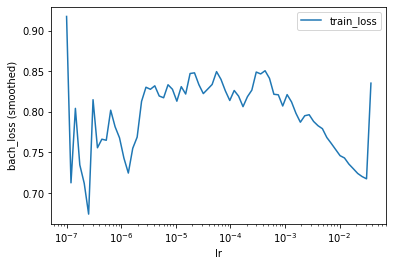

In [ ]:
batch_size = 50
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [ ]:
lr_finder.get_best_lr()


0.0001

In [ ]:
model.optimizer.set_lr(0.0001)


In [ ]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 1.1382,	val_loss: 0.3568
1:	[0s / 0s],		train_loss: 0.5577,	val_loss: 0.3559
2:	[0s / 0s],		train_loss: 0.8945,	val_loss: 0.3553
3:	[0s / 0s],		train_loss: 0.9652,	val_loss: 0.3549
4:	[0s / 0s],		train_loss: 1.3153,	val_loss: 0.3549
5:	[0s / 0s],		train_loss: 0.7897,	val_loss: 0.3548
6:	[0s / 0s],		train_loss: 0.7750,	val_loss: 0.3546
7:	[0s / 0s],		train_loss: 0.6511,	val_loss: 0.3552
8:	[0s / 0s],		train_loss: 0.8995,	val_loss: 0.3555
9:	[0s / 0s],		train_loss: 0.8993,	val_loss: 0.3564
10:	[0s / 0s],		train_loss: 1.0945,	val_loss: 0.3569
11:	[0s / 0s],		train_loss: 0.8863,	val_loss: 0.3564
12:	[0s / 0s],		train_loss: 1.7303,	val_loss: 0.3574
13:	[0s / 0s],		train_loss: 0.5061,	val_loss: 0.3576
14:	[0s / 0s],		train_loss: 0.9115,	val_loss: 0.3573
15:	[0s / 0s],		train_loss: 0.8989,	val_loss: 0.3574
16:	[0s / 0s],		train_loss: 0.5756,	val_loss: 0.3583


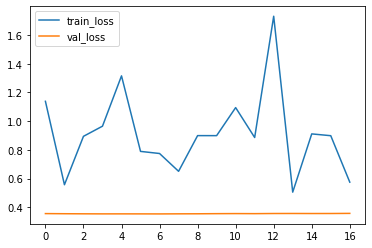

In [ ]:
_ = log.plot()


Prediction DeepHit

In [ ]:
surv = model.predict_surv_df(x_val)


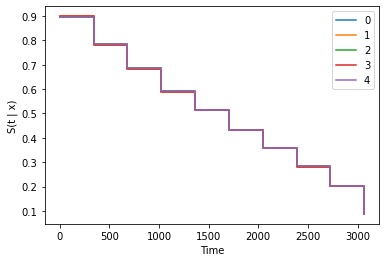

In [ ]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
surv = model.interpolate(10).predict_surv_df(x_val)


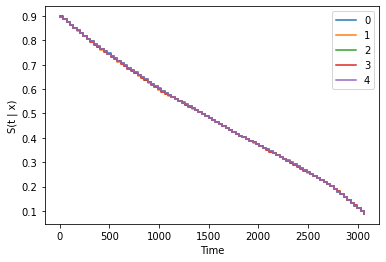

In [ ]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
ev = EvalSurv(surv, times_val, events_val, censor_surv='km')

Brier score: 0.5102989706945327


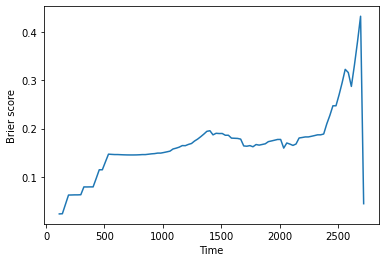

In [ ]:
time_grid = np.linspace(times_val.min(), times_val.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')
print("Brier score:",ev.integrated_nbll(time_grid))


In [ ]:
# C-index 
from lifelines.utils import concordance_index
concordance_index(times_val, predictions, events_val)


0.6684491978609626

# **DeepSurv**

In [ ]:
import torch.nn as nn
class CoxNet(nn.Module):
  """CoxPH like model"""
  def __init__(self, H1 = 32, H2 = 32):
    super(CoxNet, self).__init__()
    self.net = torch.nn.Sequential(nn.Linear(47, H1),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(H1),
                                   nn.Dropout(0.3),
                                   nn.Linear(H1, H2),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(H2),
                                   nn.Dropout(0.1),
                                   nn.Linear(H2, 1))
  
  def forward(self, x):
    return self.net(x)


In [ ]:
net = CoxNet()
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
#optimizer = tt.optim.SGD(lr=1e-3, momentum=0.9, weight_decay=3e-4, nesterov=True)
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,cycle_multiplier=2)
model = CoxPH(net, optimizer = optimizer, device = device)

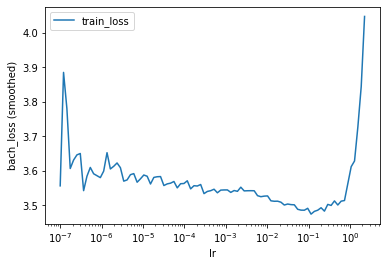

0.01149756995397742


In [ ]:
batch_size = 50 
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
# Learning rate finder often overestimate the learning rate so choose a lower value
lrfinder.plot()
plt.show()
print(lrfinder.get_best_lr())

0:	[0s / 0s],		train_loss: 3.6819,	val_loss: 3.6279
1:	[0s / 0s],		train_loss: 3.3424,	val_loss: 3.6113
2:	[0s / 0s],		train_loss: 3.3906,	val_loss: 3.6080
3:	[0s / 0s],		train_loss: 3.4498,	val_loss: 3.5880
4:	[0s / 0s],		train_loss: 3.3896,	val_loss: 3.5645
5:	[0s / 0s],		train_loss: 3.3455,	val_loss: 3.5629
6:	[0s / 0s],		train_loss: 3.4997,	val_loss: 3.5572
7:	[0s / 0s],		train_loss: 3.2316,	val_loss: 3.5878
8:	[0s / 0s],		train_loss: 3.2359,	val_loss: 3.6021
9:	[0s / 0s],		train_loss: 3.2756,	val_loss: 3.5791
10:	[0s / 0s],		train_loss: 3.2408,	val_loss: 3.5286
11:	[0s / 0s],		train_loss: 3.1728,	val_loss: 3.5478
12:	[0s / 0s],		train_loss: 3.2063,	val_loss: 3.5459
13:	[0s / 0s],		train_loss: 3.2347,	val_loss: 3.5374
14:	[0s / 0s],		train_loss: 3.0463,	val_loss: 3.5398
15:	[0s / 0s],		train_loss: 3.2214,	val_loss: 3.4810
16:	[0s / 0s],		train_loss: 3.0633,	val_loss: 3.4976
17:	[0s / 0s],		train_loss: 3.0516,	val_loss: 3.5061
18:	[0s / 0s],		train_loss: 3.1059,	val_loss: 3.4980
19:

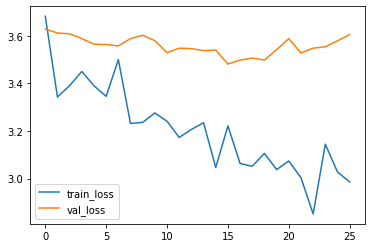

-3.481001377105713


In [ ]:
model.optimizer.set_lr(0.01)
batch_size = 50
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=(x_val,y_val), val_batch_size=batch_size)
log.plot()
plt.show()
print(model.partial_log_likelihood(*(x_val,y_val)).mean())

/usr/local/lib/python3.7/dist-packages/pycox/models/cox.py:257: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


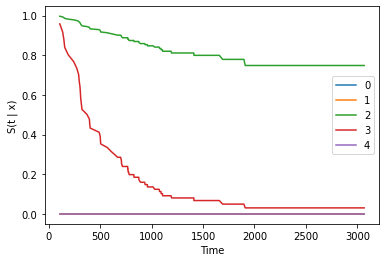

In [ ]:
# Predicted survival curve on validation set for 5 patients
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)
surv.iloc[:,:5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

0.7085561497326203
0.5085983168948585


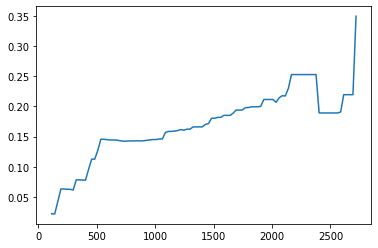

In [ ]:
# Predicted survival metrics ie. Concordance index and Brier score on validation set
dur = times_val
eve = events_val
ev = EvalSurv(surv, dur, eve, censor_surv='km')
print(ev.concordance_td())
time_grid = np.linspace(dur.min(), dur.max(), 100)
_ = ev.brier_score(time_grid).plot()
print(ev.integrated_nbll(time_grid))

## **3.Prediction**

In [ ]:

def Concordance_index(event_times, predicted_scores, event_observed=None):
    """
    Code adapted from https://github.com/CamDavidsonPilon/lifelines/blob/master/lifelines/utils/concordance.py
    to account for missing values in the context of the HECKTOR Challenge
    Missing values are encoded by NaNs and are computed as non-concordant.
    """
    event_times, predicted_scores, event_observed = _preprocess_scoring_data(
        event_times, predicted_scores, event_observed)
    # num_correct, num_tied, num_pairs = _concordance_summary_statistics(
    #     event_times, predicted_scores, event_observed)
    num_correct, num_tied, num_pairs = _naive_concordance_summary_statistics(
        event_times, predicted_scores, event_observed)

    return _concordance_ratio(num_correct, num_tied, num_pairs)


def _concordance_ratio(num_correct, num_tied, num_pairs):
    """
    Code adapted from https://github.com/CamDavidsonPilon/lifelines/blob/master/lifelines/utils/concordance.py
    to account for missing values in the context of the HECKTOR Challenge
    """
    if num_pairs == 0:
        raise ZeroDivisionError("No admissable pairs in the dataset.")
    return (num_correct + num_tied / 2) / num_pairs


def _naive_concordance_summary_statistics(event_times, predicted_event_times,
                                          event_observed):
    """
    Code adapted from https://github.com/CamDavidsonPilon/lifelines/blob/master/lifelines/utils/concordance.py
    to account for missing values in the context of the HECKTOR Challenge
    """
    def _valid_comparison(time_a, time_b, event_a, event_b):
        """True if times can be compared."""
        if time_a == time_b:
            # Ties are only informative if exactly one event happened
            return event_a != event_b
        if event_a and event_b:
            return True
        if event_a and time_a < time_b:
            return True
        if event_b and time_b < time_a:
            return True
        return False

    def _concordance_value(time_a, time_b, pred_a, pred_b, event_a, event_b):
        if np.isnan(pred_a) or np.isnan(pred_b):
            # Missing values, same as random
            return (0, 1)
        if pred_a == pred_b:
            # Same as random
            return (0, 1)
        if pred_a < pred_b:
            return (time_a < time_b) or (time_a == time_b and event_a
                                         and not event_b), 0
        # pred_a > pred_b
        return (time_a > time_b) or (time_a == time_b and not event_a
                                     and event_b), 0

    num_pairs = 0.0
    num_correct = 0.0
    num_tied = 0.0

    for a, time_a in enumerate(event_times):
        pred_a = predicted_event_times[a]
        event_a = event_observed[a]
        # Don't want to double count
        for b in range(a + 1, len(event_times)):
            time_b = event_times[b]
            pred_b = predicted_event_times[b]
            event_b = event_observed[b]

            if _valid_comparison(time_a, time_b, event_a, event_b):
                num_pairs += 1.0
                crct, ties = _concordance_value(time_a, time_b, pred_a, pred_b,
                                                event_a, event_b)
                num_correct += crct
                num_tied += ties

    return (num_correct, num_tied, num_pairs)


def _preprocess_scoring_data(event_times, predicted_scores, event_observed):
    """
    Code adapted from https://github.com/CamDavidsonPilon/lifelines/blob/master/lifelines/utils/concordance.py
    to account for missing values in the context of the HECKTOR Challenge
    """
    event_times = np.asarray(event_times, dtype=float)
    predicted_scores = np.asarray(predicted_scores, dtype=float)

    # Allow for (n, 1) or (1, n) arrays
    if event_times.ndim == 2 and (event_times.shape[0] == 1
                                  or event_times.shape[1] == 1):
        # Flatten array
        event_times = event_times.ravel()
    # Allow for (n, 1) or (1, n) arrays
    if predicted_scores.ndim == 2 and (predicted_scores.shape[0] == 1
                                       or predicted_scores.shape[1] == 1):
        # Flatten array
        predicted_scores = predicted_scores.ravel()

    if event_times.shape != predicted_scores.shape:
        raise ValueError(
            "Event times and predictions must have the same shape")
    if event_times.ndim != 1:
        raise ValueError("Event times can only be 1-dimensional: (n,)")

    if event_observed is None:
        event_observed = np.ones(event_times.shape[0], dtype=float)
    else:
        event_observed = np.asarray(event_observed, dtype=float).ravel()
        if event_observed.shape != event_times.shape:
            raise ValueError(
                "Observed events must be 1-dimensional of same length as event times"
            )
    # Commented out since we rely on NaNs to count missing patients
    # check for NaNs
    # for a in [event_times, predicted_scores, event_observed]:
    #     if np.isnan(a).any():
    #         raise ValueError(
    #             "NaNs detected in inputs, please correct or drop.")

    return event_times, predicted_scores, event_observed

In [ ]:
Concordance_index(times_val,  predictions, event_observed=events_val) 

0.8101604278074866

In [ ]:
def predict(prediction, threshold=0.9):
    surv_predictions = []
    for _, pred in prediction.iteritems():
        times = pred.index.values
        for time in times:
          if pred[time] <= threshold:
            t = time
            break
        else:
          t = times[-1]
        surv_predictions.append(t)
    return pd.DataFrame(np.array([surv for surv in surv_predictions]), columns=['Progression free survival'])

# CoxPH Survival Model Ensembling (average) on different train-val splits:
models = []
models = [survival + str(i) for i in range(10)]
pred = []
pred = [predict(model, 0.9) for model in models]
predictions = np.mean(pred)

In [ ]:
print(predictions)

0      241.0
1     3067.0
2      781.0
3     3067.0
4     1029.0
5     1091.0
6     1411.0
7      146.0
8     3067.0
9      499.0
10     707.0
11     295.0
12     499.0
13    3067.0
14    1106.0
15    3067.0
16    1910.0
17     489.0
18    3067.0
19    3067.0
20     935.0
21    1690.0
22     705.0
23    3067.0
24    1411.0
25    1690.0
26    3067.0
27     768.0
28    3067.0
29     771.0
30     322.0
31     705.0
32     489.0
33     828.0
34    1194.0
35     707.0
36     768.0
37     272.0
38     771.0
39     322.0
40    1106.0
41     828.0
42    1910.0
43    3067.0
44     502.0
Name: Progression free survival, dtype: float64


# **4.Submission**

In [ ]:
# Generate Submission File 
Submission = pd.DataFrame({'PatientID': TEST['PatientID'],'Progression Free Survival': -predictions}) 
Submission.to_csv("Submission.csv", index=False)